## Experimental Environment Set Up
1. Clone https://github.com/tklab-group/tomcat-jisdlab-demo (commit 639f7da)
1. Set the absolute path of apache-tomcat-9.0.41 to the environment variable `CATALINA_HOME`.
1. Run `gradlew.bat`
1. Run `gradle war`
1. Confirm that TomcatDemo-0.0.2.war has been created in apache-tomcat-9.0.41/webapps.

1. Set up JISDLab on Windows (please see https://tklab-group.github.io/JISDLab/contents/en/installation/index.html. \<your classpath\> is `%JISDLAB_HOME%/sample`)
1. Run `jupyter lab` in the JISDLab directory
1. Run the following in PowerShell
   ```sh
   $env:PROBEJ_PORT=39876; cmd.exe /c %CATALINA_HOME%/bin/catalina.bat probej start
   ```

# Case: Identifying bottlenecks

In [1]:
var dbg = new Debugger("localhost", 39876, true); // Using ProbeJ

### Set up observation points at the boundary of each section

In [2]:
dbg.run();
String[] vars = {"noOfViews"};
List<Integer> lines = List.of(20, 22, 24, 26, 28);
var points = lines.stream()
                  .map(line -> dbg.watch("tomcatdemo.App", line, vars).get())
                  .collect(Collectors.toList());

Try to connect to localhost:39876
Succeccfully connected to localhost:39876
>> Debugger Info: Debugger started.


Visit http://localhost:8080/TomcatDemo-0.0.2/home 15 times (Please wait for the page to refresh before accessing it)．

### Display of observation results(n=15)

In [3]:
var values =  new ArrayList<ValueInfo>();
points.forEach(p -> {
  var dr = p.getResults().get(vars[0]);
  var latestValue = dr.getLatestValue();
  values.add(latestValue);
  println("value\t:\ttimestamp");
  println(latestValue.getValue()+"\t:\t"+latestValue.getCreatedAt());
})

value	:	timestamp
15	:	2021-11-18T19:39:08.347
value	:	timestamp
15	:	2021-11-18T19:39:08.667
value	:	timestamp
15	:	2021-11-18T19:39:08.725
value	:	timestamp
15	:	2021-11-18T19:39:10.720
value	:	timestamp
15	:	2021-11-18T19:39:10.927


### Visualization of processing time for each section

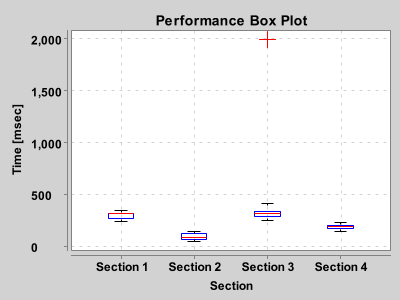

In [4]:
import java.time.LocalDateTime;
import java.time.temporal.ChronoUnit;
import org.knowm.xchart.style.BoxStyler.BoxplotCalCulationMethod;
// the number of access 
int maxSize = points.get(0).getResults().get(vars[0]).getValues().size();
// create chart
BoxChart chart = new BoxChartBuilder().width(400).height(300).title("Performance Box Plot")
                                      .xAxisTitle("Section").yAxisTitle("Time [msec]").build();
for (int i = 0; i < 4; i++) {
    List<Double> list = new ArrayList<>();
    var vs0 = points.get(i).getResults().get(vars[0]).getValues(); // get a start probe point 
    var vs1 = points.get(i+1).getResults().get(vars[0]).getValues(); // get a end probe point
    for (int j = 0; j < maxSize; j++) {
        var v0 = vs0.get(j); // get values at the start probe point
        var v1 = vs1.get(j); // get values at the end probe point
        Long diff = ChronoUnit.MILLIS.between(v0.getCreatedAt(), v1.getCreatedAt()); // get time diff
        list.add(Double.valueOf(diff));
    }
    // series
    chart.addSeries("Section "+(i+1), list);
}

// choose a calculation method
chart.getStyler().setBoxplotCalCulationMethod(BoxplotCalCulationMethod.N_LESS_1_PLUS_1);
chart.getStyler().setToolTipsEnabled(true);
BitmapEncoder.getBufferedImage(chart);

### Survey results
- The bug is in **Section 3** 

In [5]:
dbg.exit();

>> Debugger Info: Debugger exited.
